In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from polling_simulator import Demographic, Variable, generate_electorate, run_elections, run_polls
from polling_simulator.aggregation import naive_aggregation, stratified_aggregation, weight_by_self_reported_turnout
from polling_simulator.distributions import truncated_gaussian_distribution
from polling_simulator.sampling import predefined_sample

original_palette = sns.color_palette()
modified_palette = [original_palette[0], original_palette[3]]
sns.set_palette(modified_palette)

The electorate isn't a uniform blob like it was in the first example, but rather contains many different groups which may have different candidate preferences as well as different ways to interact with the polls. Let's set up another example, this time using different demographics based on age.

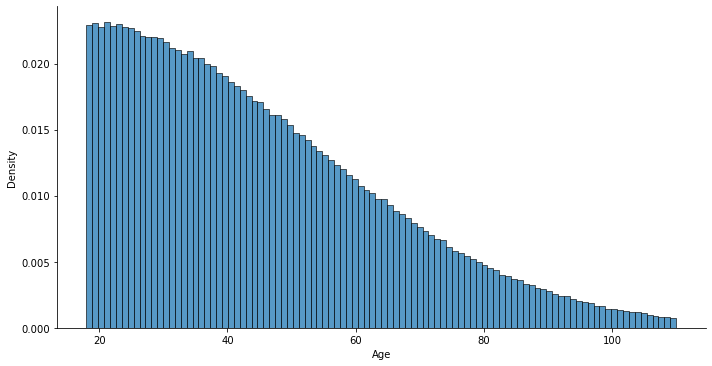

In [2]:
age = Variable("age", truncated_gaussian_distribution(18, 35, 18, 110))

random_ages = age.data_generator(1000000)
fig = sns.displot(random_ages, bins=100, stat="density", height=5, aspect=2)
fig.set(xlabel="Age")

In [3]:
age_lt_30 = Demographic(
    turnout_likelihood=0.3,
    response_likelihood=1.0,
    candidate_preference={"Rep": 0.2, "Dem": 0.8},
    population_segmentation=(age < 30)
)
age_between_30_50 = Demographic(
    turnout_likelihood=0.5,
    response_likelihood=1.0,
    candidate_preference={"Rep": 0.4, "Dem": 0.6},
    population_segmentation=(age >= 30) & (age < 50)
)
age_between_50_65 = Demographic(
    turnout_likelihood=0.6,
    response_likelihood=1.0,
    candidate_preference={"Rep": 0.6, "Dem": 0.4},
    population_segmentation=(age >= 50) & (age < 65)
)
age_ge_65 = Demographic(
    turnout_likelihood=0.9,
    response_likelihood=1.0,
    candidate_preference={"Rep": 0.75, "Dem": 0.25},
    population_segmentation=(age >= 65)
)
demographics = [age_lt_30, age_between_30_50, age_between_50_65, age_ge_65]

In [4]:
np.random.seed(123)
electorate = generate_electorate(1000000, demographics)

In [5]:
simulated_elections = run_elections(100, electorate)
simulated_elections["total_votes"] = simulated_elections.sum(axis=1)
simulated_elections["dem_voteshare"] = simulated_elections["Dem"] / simulated_elections["total_votes"]
simulated_elections["rep_voteshare"] = simulated_elections["Rep"] / simulated_elections["total_votes"]

(0.4, 0.6)

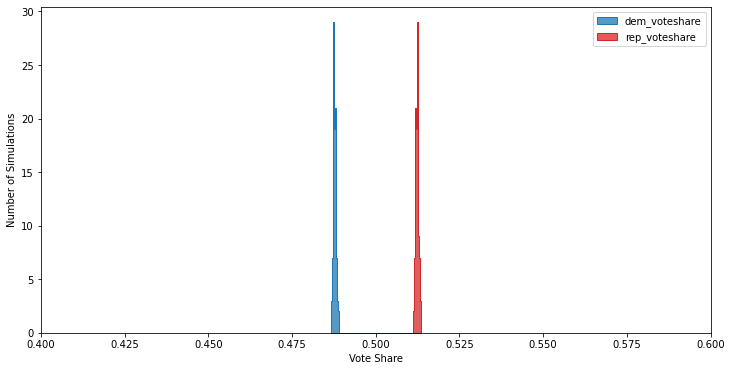

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    simulated_elections[["dem_voteshare", "rep_voteshare"]], element="step", bins=100, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.4, 0.6])

In [7]:
# This cell may take ~10 minutes
naive_poll_results = run_polls(
    num_polls=500,
    num_to_poll=1000,
    electorate=electorate,
    assumed_demographics=demographics,
    sampling_strategy=predefined_sample(max_num_attempts=1, screen_likely_voters=False),
    aggregation_strategy=naive_aggregation()
)

(0.4, 0.6)

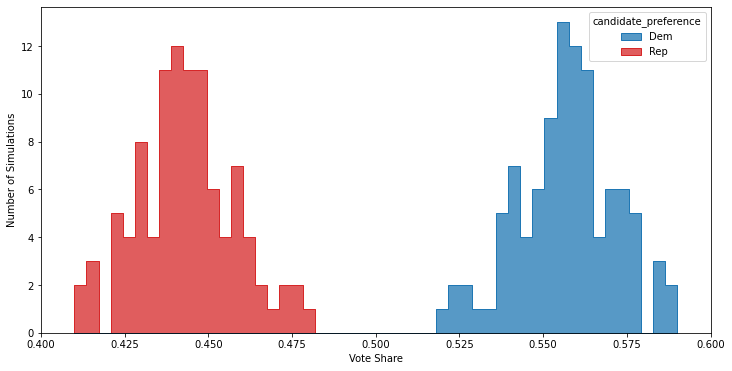

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    naive_poll_results[["Dem", "Rep"]], element="step", bins=50, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.40, 0.60])

In [9]:
# This cell may take ~10 minutes
weighted_poll_results = run_polls(
    num_polls=500,
    num_to_poll=1000,
    electorate=electorate,
    assumed_demographics=demographics,
    sampling_strategy=predefined_sample(max_num_attempts=1, screen_likely_voters=False),
    aggregation_strategy=naive_aggregation(turnout_weighting=weight_by_self_reported_turnout())
)

(0.4, 0.6)

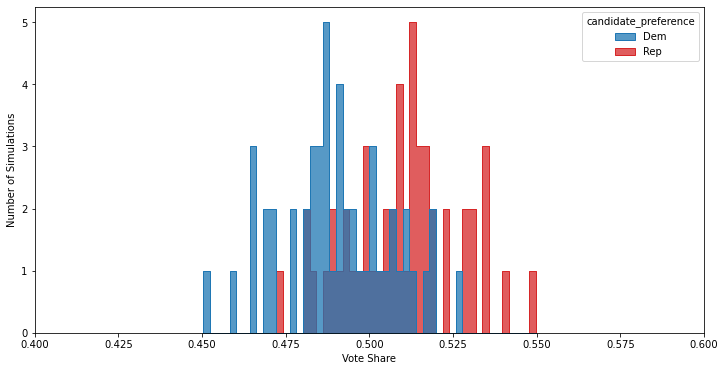

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    weighted_poll_results[["Dem", "Rep"]], element="step", bins=50, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.40, 0.60])

In [ ]:
stratification = stratified_aggregation(
    demographics,
    [demographic.population_segmentation.segment(electorate).sum() / len(electorate) for demographic in demographics]
)